In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
sys.path.append('..')
from m1_main import prospect_delegation


In [ ]:
data_set = 'leadership_data'
model = 'prospect_delegation'
method = 'mle' 
fname = f'../data/infer_data-{data_set}-{model}-{method}.csv'
infer_data = pd.read_csv(fname)
sub_lst = infer_data['sub_id'].unique()
samples = np.random.choice(sub_lst, 5)
fname = f'../data/leadership_data.csv'
human_data = pd.read_csv(fname)
human_data['p_defer'] = human_data['Fishing'].apply(lambda x: x==1)
fig, axs = plt.subplots(5, 3, figsize=(4, 6), sharey=True)
for i, sub_id in enumerate(samples):
    sns.lineplot(data=human_data.query('sub_id == @sub_id'), x='ObjectiveValue', y='p_defer',
                hue='sub_id', ax=axs[i, 0], legend=False)
    sns.lineplot(data=infer_data.query('sub_id == @sub_id'), x='ObjectiveValue', y='p_defer',
                hue='sub_id', ax=axs[i, 1], legend=False)
    sns.lineplot(data=infer_data.query('sub_id == @sub_id'), x='SubjectiveValue', y='p_defer',
                hue='sub_id', ax=axs[i, 2], legend=False)
plt.tight_layout()
plt.show()

In [24]:
import pingouin as pg 

In [26]:
d = infer_data
pg.corr(d['ObjectiveValue'].values, d['SubjectiveValue'].values)

,n,r,CI95%,p-val,BF10,power
pearson,634,0.97337,"[0.97, 0.98]",0.0,nan,1.0


In [33]:
data_set = 'leadership_data'
model = 'prospect_delegation'
method = 'mle' 
def get_params(data_set, model, method, p_trans=None):
    fname = f'../data/fit_info-{data_set}-{model}-{method}.pkl'
    with open(fname, 'rb') as handle: fit_info = pickle.load(handle)
    param_names = fit_info[list(fit_info.keys())[0]]['param_name']
    df = {p: [] for p in param_names}
    df['sub_id'] = []
    for sub_id, item in fit_info.items():
        params = item['param']
        if p_trans is not None:
            params = [fn(p) for p, fn in zip(params, p_trans)]
        df['sub_id'].append(sub_id)
        for i, n in enumerate(param_names): df[n].append(params[i])
    return pd.DataFrame(df)[['sub_id'] + param_names]

In [34]:
data_set = 'leadership_data_type1'
get_params(data_set, model, method, p_trans=eval(model).p_trans)

,sub_id,theta,lmbda,gamma,tau,b,kappa,sigma
0,Sub111_lyb_leadership,0.479377,1.188043,0.257630,529.343123,-0.130946,1.060443,0.002638
1,Sub106_zsh_leadership,0.343757,1.451130,0.379951,159.141879,-0.560923,0.861724,0.008468


In [32]:
data_set = 'leadership_data_type2'
get_params(data_set, model, method, p_trans=eval(model).p_trans)


,sub_id,theta,lmbda,gamma,tau,b,kappa,sigma
0,Sub111_lyb_leadership,0.477760,1.344275,2.519157,37.009728,-0.222347,0.698683,0.079535
1,Sub106_zsh_leadership,0.372445,1.394416,2.362507,20.686108,-0.224271,0.739345,0.079531


In [29]:
## simulate
def sim(params):

    data_set = 'leadership_data'
    model = 'prospect_delegation'
    method = 'mle' 
    # load the data for inference
    fname = f'../data/{data_set}.pkl'
    with open(fname, 'rb') as handle: data = pickle.load(handle)
    
    model_name = 'prospect_delegation'
    nA = 2 # the number of possible choices
    model = eval(model_name)
    params = [f(p) for p, f in zip(params, model.p_links)]
    print([f(p) for p, f in zip(params, model.p_trans)])


    infer_data = [] 
    print('\nInferring the latent variables...')
    for sub_id, sub_data in data.items():
        # get the fitted params for inference
        fitted_params = params#fit_sub_info[sub_id]['param']

        for sub_id in sub_data.keys():
            # instantiate the subject model
            block_data = sub_data[sub_id].copy()
            subj = model(nA, fitted_params)

            # initialize a blank dataframe to store the inference results
            col = ['ll'] + model.hidden_vars
            init_mat = np.zeros([block_data.shape[0], len(col)]) + np.nan
            pred_data = pd.DataFrame(init_mat, columns=col)  

            for t, row in block_data.iterrows():
                # make a decision 
                z_gain = row['Zgain']
                z_loss = row['Zloss']
                z_uncertain = row['Uncertainty']
                response = row['Response']

                # if the participant response, calculate the likelihood
                if response: 
                    pi = subj.policy(z_gain, z_loss, z_uncertain, x_gain=.2, x_loss=-.2)
                    a = row['Fishing']
                
                    # store the hidden variables 
                    pred_data.loc[t, 'll'] = np.log(pi[a]+1e-12)
                    for v in model.hidden_vars: 
                        pred_data.loc[t, v] = eval(f'subj.{v}')
            
            # combine the subject data and inferred hidden variables
            pred_data = pred_data.dropna(axis=1, how='all')
            infer_datum = pd.concat([block_data, pred_data], axis=1)   
            infer_data.append(infer_datum)

    # combine the inferred data from all subjects and save it
    infer_data = pd.concat(infer_data, axis=0).reset_index(drop=True)
    return infer_data 

[0.5, 1.000000000003, 0.9999999999999999, 5.000000000001, 0.1, 0.500000000001, 0.05000000000100001]

Inferring the latent variables...


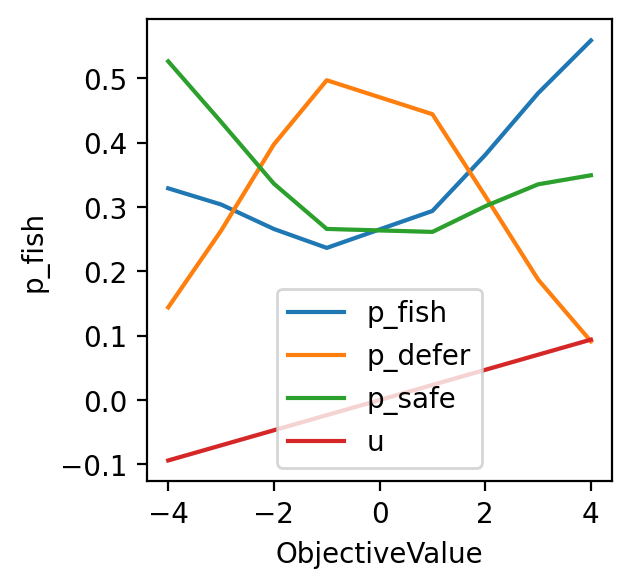

In [30]:
sim_data = sim([0.5, 1, 1, 5, .1, .5, .05])
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
for a in ['p_fish', 'p_defer', 'p_safe', 'u']:
    sns.lineplot(data=sim_data, x='ObjectiveValue', 
                 y=a, ax=ax, label=a)
plt.show()